In [1]:
%matplotlib inline
import theano
import pymc3 as pm
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\seolbluewings\AppData\Local\Continuum\anaconda3\lib\site-packages\theano\configdefaults.py:697: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  "DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
C:\Users\seolbluewings\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWar

#### Sample 데이터셋 생성 

In [27]:
x,y = make_moons(noise=0.2, n_samples=1000, random_state = 50120057)
x = scale(x)
x_tr, x_ts, y_tr, y_ts = train_test_split(x, y, test_size =0.3)

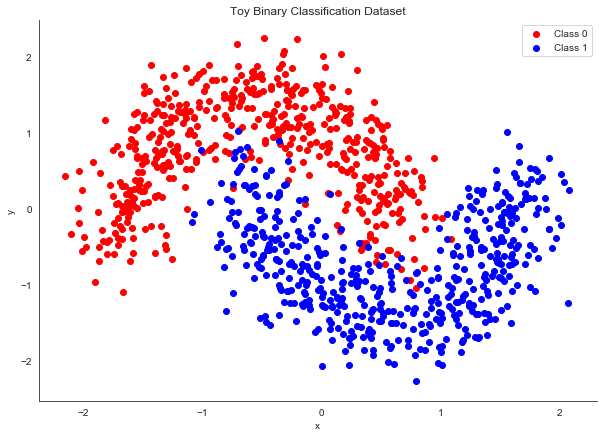

In [33]:
fig, ax = plt.subplots(figsize = (10,7))
ax.scatter(x[y==0,0],x[y==0,1], label = 'Class 0', color = 'r')
ax.scatter(x[y==1,0],x[y==1,1], label = 'Class 1', color = 'b')
sns.despine()
ax.legend()
ax.set(xlabel = 'x', ylabel = 'y', title = 'Toy Binary Classification Dataset');

- PyMC3은 theano 기반으로 동작
- PyMC3에서는 with 구문으로 모델 정의
- Hidden Layer가 2층이며 각 Layer에서는 10개의 Neuron이 존재하는 경우에 대한 모델을 생성

In [ ]:
def construct_nn(ann_input, ann_output) :
    n_hidden = 10
    
    # Initialize random weighs between each Layer
    
    

In [4]:
def construct_nn(ann_input, ann_output):
    n_hidden = 5
    
    # Initialize random weights between each layer
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(float)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(float)
    init_out = np.random.randn(n_hidden).astype(float)
        
    with pm.Model() as neural_network:
        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sd=1, 
                                 shape=(X.shape[1], n_hidden), 
                                 testval=init_1)
        
        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sd=1, 
                                shape=(n_hidden, n_hidden), 
                                testval=init_2)
        
        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sd=1, 
                                  shape=(n_hidden,), 
                                  testval=init_out)
        
        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input, 
                                         weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, 
                                         weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2, 
                                              weights_2_out))
        
        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out', 
                           act_out,
                           observed=ann_output,
                           total_size=Y_train.shape[0] # IMPORTANT for minibatches
                          )
    return neural_network

# Trick: Turn inputs and outputs into shared variables. 
# It's still the same thing, but we can later change the values of the shared variable 
# (to switch in the test-data later) and pymc3 will just use the new data. 
# Kind-of like a pointer we can redirect.
# For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)
neural_network = construct_nn(ann_input, ann_output)

In [5]:
from pymc3.theanof import set_tt_rng, MRG_RandomStreams
set_tt_rng(MRG_RandomStreams(42))

In [6]:
%%time

with neural_network:
    inference = pm.ADVI()
    approx = pm.fit(n=1000, method=inference)

Finished [100%]: Average Loss = 618.07


Wall time: 3min 7s


In [7]:
trace = approx.sample(draws=1000)

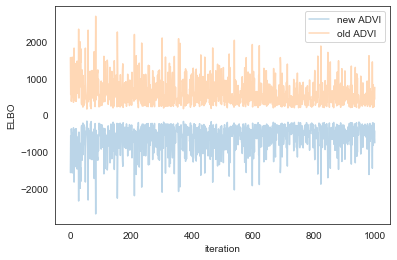

In [8]:
plt.plot(-inference.hist, label="new ADVI", alpha=0.3)
plt.plot(approx.hist, label="old ADVI", alpha=0.3)
plt.legend()
plt.ylabel("ELBO")
plt.xlabel("iteration");

In [10]:
# Replace arrays our NN references with the test data
ann_input.set_value(X_test)
ann_output.set_value(Y_test)

with neural_network:
    ppc = pm.sample_posterior_predictive(trace, samples=500, progressbar=False)

# Use probability of > 0.5 to assume prediction of class 1
pred = ppc['out'].mean(axis=0) > 0.5

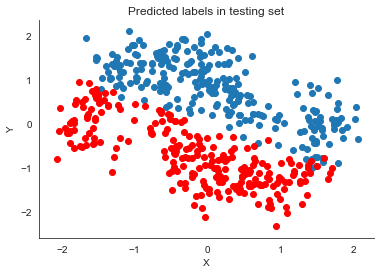

In [11]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
sns.despine()
ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y');

In [13]:
grid = pm.floatX(np.mgrid[-3:3:100j,-3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [14]:
ann_input.set_value(grid_2d)
ann_output.set_value(dummy_out)

with neural_network:
    ppc = pm.sample_posterior_predictive(trace, samples=500, progressbar=False)

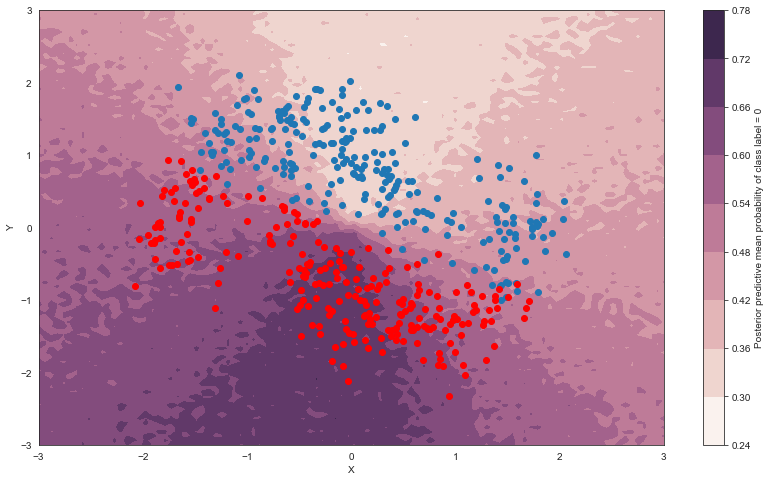

In [17]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(14, 8))
contour = ax.contourf(grid[0], grid[1], ppc['out'].mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

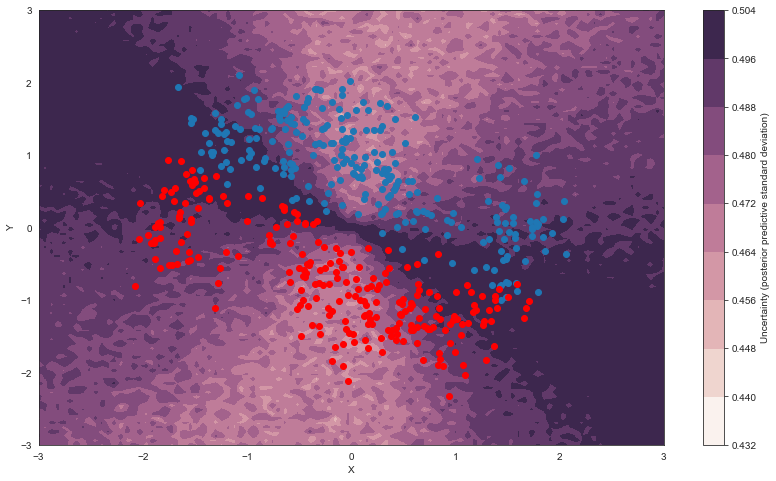

In [16]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(14, 8))
contour = ax.contourf(grid[0], grid[1], ppc['out'].std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

In [20]:
minibatch_x = pm.Minibatch(X_train, batch_size=32)
minibatch_y = pm.Minibatch(Y_train, batch_size=32)

neural_network_minibatch = construct_nn(minibatch_x, minibatch_y)
with neural_network_minibatch:
    inference = pm.ADVI()
    approx = pm.fit(1000, method=inference)

Finished [100%]: Average Loss = 37.13


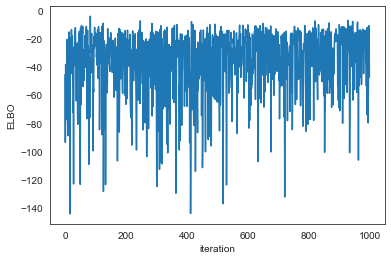

In [21]:
plt.plot(-inference.hist)
plt.ylabel('ELBO')
plt.xlabel('iteration');

In [22]:
pm.traceplot(trace);

ValueError: operands could not be broadcast together with shapes (100,) (1,) (1,) (10000,) (1,) 
Apply node that caused the error: Elemwise{Composite{Switch(Cast{int8}((GE(Cast{int64}(i0), i1) * LE(Cast{int64}(i0), i2) * GE(scalar_sigmoid(i3), i1) * LE(scalar_sigmoid(i3), i2))), Switch(Cast{int64}(i0), (-scalar_softplus((-i3))), (-scalar_softplus(i3))), i4)}}[(0, 3)](<TensorType(float64, vector)>, TensorConstant{(1,) of 0}, TensorConstant{(1,) of 1}, Gemv{inplace}.0, TensorConstant{(1,) of -inf})
Toposort index: 7
Inputs types: [TensorType(float64, vector), TensorType(int8, (True,)), TensorType(int8, (True,)), TensorType(float64, vector), TensorType(float32, (True,))]
Inputs shapes: [(100,), (1,), (1,), (10000,), (1,)]
Inputs strides: [(8,), (1,), (1,), (8,), (4,)]
Inputs values: ['not shown', array([0], dtype=int8), array([1], dtype=int8), 'not shown', array([-inf], dtype=float32)]
Outputs clients: [['output']]

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.
HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.